# Gaussian naive bayes model for handwritten digits recognition
### Dmytro Rudkovskyi 
## BrainStation Vancouver

### Import libs

In [1]:
import os
from PIL import Image
import PIL.ImageOps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as m3d
from sklearn.naive_bayes import GaussianNB
import timeit

starttime = timeit.timeit()

### List of images with digits for future train and prediction sets

In [2]:
imagearr = []
for filename in os.listdir('C:\\Users\\NULL\\Desktop\\BS_project\\scan'):
    image = Image.open('C:\\Users\\NULL\\Desktop\\BS_project\\scan\\' + filename)
    imagearr.append(image)
    del image

### Digits set 1

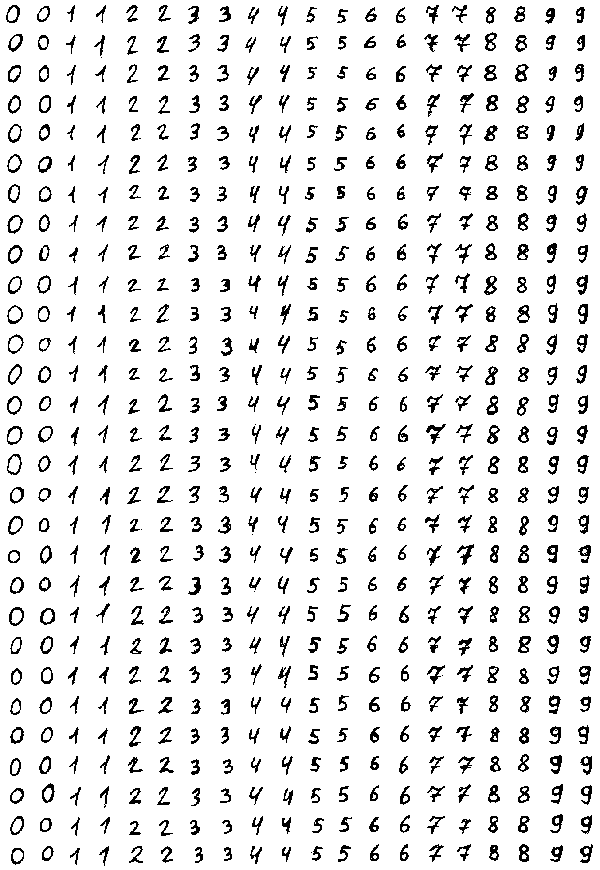

In [3]:
imagearr[0]

### Digits set 2

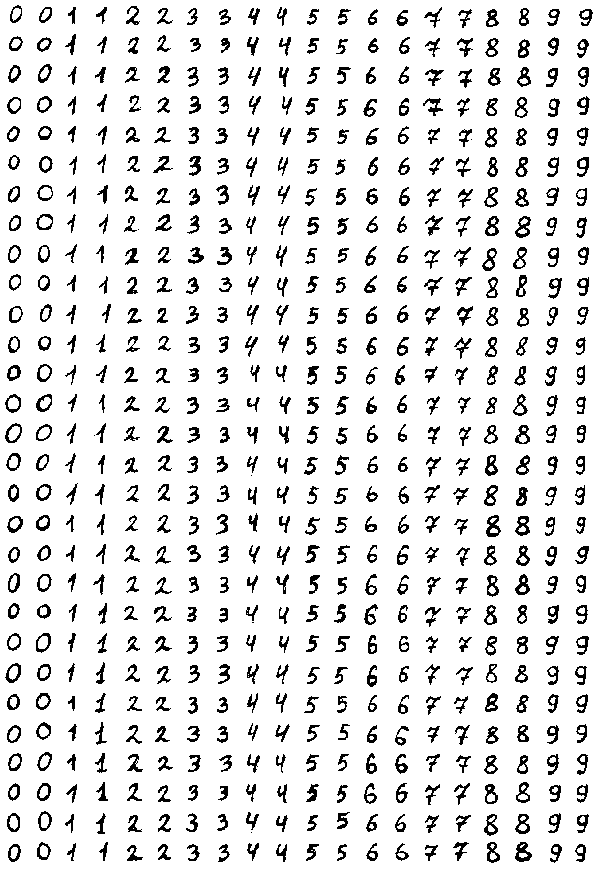

In [4]:
imagearr[1]

### Digits set 3

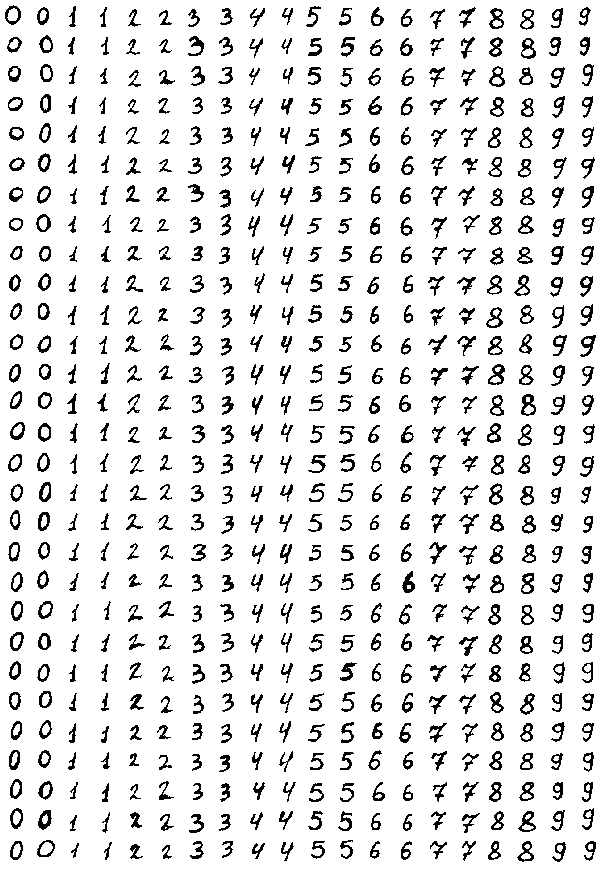

In [5]:
imagearr[2]

### Func for search exact coordinates of the digit (helps with cropping and stretching images)

In [6]:
def naive_cords2(image):
    start_list = list(image.getdata())
    err1 = 1
        
    left_pixel = []
    top_pixel = []
    right_pixel = []
    bottom_pixel = []
    arr_rng = range(err1, 30-err1)
    
    for count in arr_rng:
        left_pixel.append([0,0])
        top_pixel.append([0,0])
        right_pixel.append([0,0])
        bottom_pixel.append([0,0])
            
    for search in arr_rng:
        counter = err1
        for item in left_pixel:
            item[0] = search if ((start_list[counter*30 + search] == 0) and (item[0] == 0)) else item[0]
            item[1] += 1 if (start_list[counter*30 + search] == 0) else item [1]
            counter+=1
        
        counter = err1
        for item in top_pixel:
            item[0] = search if ((start_list[search*30 + counter] == 0) and (item[0] == 0)) else item[0]
            item[1] += 1 if (start_list[search*30 + counter] == 0) else item [1]
            counter+=1
        
        counter = err1
        for item in right_pixel:
            item[0] = (30 - search) if ((start_list[counter*30 + 30 - search] == 0) and (item[0] == 0)) else item [0]
            item[1] += 1 if (start_list[counter*30 + 30 - search] == 0) else item [1]
            counter+=1
            
        counter = err1
        for item in bottom_pixel:
            item[0] = (30 - search) if ((start_list[(30-search)*30 + counter] == 0) and (item[0] == 0)) else item [0]
            item[1] += 1 if (start_list[counter*30 + search] == 0) else item [1]
            counter+=1
            
    left, top, right, bottom = 0, 0, 0, 0
    
    left = 30 - err1;
    for i in left_pixel:
        left = i[0] if ((i[0] < left) and i[0] > 0) else left
    top = 30 - err1;
    for i in top_pixel:
        top = i[0] if ((i[0] < top) and i[0] > 0) else top
    right = err1;
    for i in right_pixel:
        right = i[0] if ((i[0] > right) and i[0] > 0) else right
    bottom = err1;
    for i in bottom_pixel:
        bottom = i[0] if ((i[0] > bottom) and i[0] > 0) else bottom
          
    return left, top, right, bottom

### Func for partial image stretching 20x20 (used before rotation func to prevent data loss)

In [7]:
def resizeim2020(image):
    temp_image = image.convert('1')
    #factor = (32 / temp_image.height) if (temp_image.height > temp_image.width) else (32 / temp_image.width)
    factorh = 20 / temp_image.height
    factorw = 20 / temp_image.width
    temp_image = temp_image.resize((round(temp_image.height * factorh), round(temp_image.width * factorw)))
    fin_image = Image.new('1', (30,30), 'white')
    #x = round(15 - (int((x2+1)*factor) - (int((x1-1)*factor)))/2)
    #y = round(15 - (int((y2+1)*factor) - (int((y1-1)*factor)))/2)
    x = round((30 - temp_image.width)/2)
    y = round((30 - temp_image.height)/2)
    fin_image.paste(temp_image, box = (x, y))
    del temp_image
    return fin_image

### Func for full image stretching 30x30 (used after rotation to fill empty spaces near the edge in case if some left)

In [8]:
def resizeim(image):
    temp_image = image.convert('1')
    factorh = 28 / temp_image.height
    factorw = 28 / temp_image.width
    temp_image = temp_image.resize((int(temp_image.height * factorh), int(temp_image.width * factorw)))
    fin_image = Image.new('1', (30,30), 'white')
    x = round((30 - temp_image.width)/2)
    y = round((30 - temp_image.height)/2)
    fin_image.paste(temp_image, box = (x, y))
    del temp_image
    return fin_image

### Func for crop with cords and temporary resize to 20x20 (used before rotation) returns new image

In [9]:
def naive_crop_temp(image, x1, y1, x2, y2):
    if(((x1>0)and(x2>0))and((y1>0)and(y1>0))):
        temp_image = image.convert('1')
        temp_image = temp_image.crop((x1-1, y1-1, x2+1, y2+1))
        new_image = resizeim2020(temp_image)
        del temp_image
        return new_image

### Func for crop with new cords and resize to 30x30 (after rotation) returns new image

In [10]:
def naive_crop2(image, x1, y1, x2, y2):
    if(((x1>0)and(x2>0))and((y1>0)and(y1>0))):
        temp_image = image.convert('1')
        temp_image = temp_image.crop((x1-1, y1-1, x2+1, y2+1))
        new_image = resizeim(temp_image)
        del temp_image
        return new_image

### Func for image rotation in negative mode (after 20x20 resize)

In [11]:
def rotateim(image, angle):
    image = image.convert('L')
    image2 = PIL.ImageOps.invert(image)
    image2 = image2.rotate(angle)
    image = PIL.ImageOps.invert(image2)
    image = image.convert('1')
    del image2
    return image

### Crop, Convert, Align, Resize (20x20), Rotate, Resize (30x30), Random Split (on Train and Predict sets)

In [12]:
def croptrain_fin(image, imagecounter):
    for i in range(20):
        for j in range(29):
            for angle in range(-16, 17, 2):
                new_image = image.crop((i*30+2, j*30+2, 28+i*30, 28+j*30)) #CROP
                fin_image = Image.new('1',(30, 30), 'white')
                
                new_image = new_image.convert("1") #CONVERT
                
                x = round((30 - new_image.width)/2) #ALIGN
                y = round((30 - new_image.height)/2)
                fin_image.paste(new_image, box = (x, y))
                
                x1, y1, x2, y2 = naive_cords2(fin_image)
                fin_image = naive_crop_temp(fin_image, x1, y1, x2, y2) #RESIZE 20x20
                
                new_image = rotateim(fin_image, angle) #ROTATE
                del fin_image
                
                x1, y1, x2, y2 = naive_cords2(new_image)
                new_image = naive_crop2(new_image, x1, y1, x2, y2) #RESIZE 33x33
                
                if (np.random.randint(0, 10)<2): #RANDOM SPLIT
                    new_image.save('C:\\Users\\NULL\\Desktop\\BS_project\\check\\' + str(i//2) + '_' + str(imagecounter) + '.tiff', 'TIFF')
                    imagecounter+=1
                else:
                    new_image.save('C:\\Users\\NULL\\Desktop\\BS_project\\train\\' + str(i//2) + '_' + str(imagecounter) + '.tiff', 'TIFF')
                    imagecounter+=1
                del new_image
    del image
    return imagecounter

### Finally process the list with our main images with digits set through these wheel reinventing functions

In [13]:
imcounter = 0
for image in imagearr:
    imcounter = croptrain_fin(image, imcounter)
    del image

### Digit examples after processing

In [14]:
images = os.listdir('C:\\Users\\NULL\\Desktop\\BS_project\\train')
image = []
for x in range ((len(images)//10)//2, len(images), len(images)//10):
    image.append([Image.open('C:\\Users\\NULL\\Desktop\\BS_project\\train\\' + images[x]), images[x][0]])

In [15]:
image[0][0]

In [16]:
image[1][0]

In [17]:
image[2][0]

In [18]:
image[3][0]

In [19]:
image[4][0]

In [20]:
image[5][0]

In [21]:
image[6][0]

In [22]:
image[7][0]

In [23]:
image[8][0]

In [24]:
image[9][0]

### Dataframe for 3D scatter with x, y, z coords

In [25]:
c = 0
df3d = pd.DataFrame(columns = [['x','y','z']])
for item, value in image:
    df_temp = pd.DataFrame({'x':list(np.arange(900)), 'y':list(item.getdata()), 'z':int(value)}, index=range(c, c+900))
    del item
    df3d = pd.concat([df3d, df_temp], axis=0)
    c+=900

In [26]:
df3d.head()

x    y  z
0  0  255  0
1  1  255  0
2  2  255  0
3  3  255  0
4  4  255  0

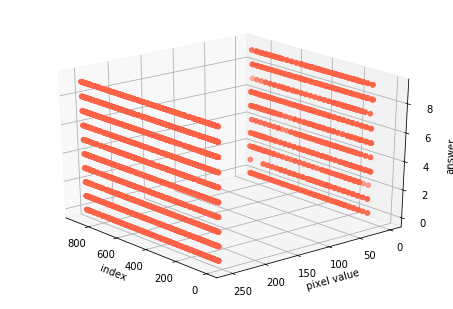

In [27]:
fig3d = m3d.Axes3D(plt.figure())
fig3d.scatter3D(df3d['x'], df3d['y'], df3d['z'], color='tomato')

fig3d.set_xlabel('index')
fig3d.set_ylabel('pixel value')
fig3d.set_zlabel('answer')

fig3d.view_init(25, 140)
plt.show()

In [28]:
del image

### Copy data from the images (training folder) to the training dataset

In [29]:
c = 0
for filename in os.listdir('C:\\Users\\NULL\\Desktop\\BS_project\\train'):
    image = Image.open('C:\\Users\\NULL\\Desktop\\BS_project\\train\\' + filename)
    image_list = list(image.getdata())
    del image
    
    df = pd.DataFrame(image_list, columns=[filename])
    del image_list
    
    if c>0:
        df_final = pd.concat([df_final, df], axis=1)
    else:
        df_final = df
    c+=1

### Int data

In [30]:
df_final.head(4)

0_0.tiff  0_1.tiff  0_10.tiff  0_10000.tiff  0_10001.tiff  0_10002.tiff  \
0       255       255        255           255           255           255   
1       255       255        255           255           255           255   
2       255       255        255           255           255           255   
3       255       255        255           255           255           255   

   0_10003.tiff  0_10004.tiff  0_10005.tiff  0_10006.tiff     ...       \
0           255           255           255           255     ...        
1           255           255           255           255     ...        
2           255           255           255           255     ...        
3           255           255           255           255     ...        

   9_9846.tiff  9_9847.tiff  9_9848.tiff  9_9849.tiff  9_9850.tiff  \
0          255          255          255          255          255   
1          255          255          255          255          255   
2          255          255          255          255          255   
3          255          255          255          255          255   

   9_9852.tiff  9_9855.tiff  9_9856.tiff  9_9858.tiff  9_9859.tiff  
0          255          255          255          255          255  
1          255          255          255          255          255  
2          255          255          255          255          255  
3          255          255          255          255          255  

[4 rows x 23604 columns]

### Bool data

In [31]:
df_b = df_final.astype('bool')
df_b.head(4)

0_0.tiff  0_1.tiff  0_10.tiff  0_10000.tiff  0_10001.tiff  0_10002.tiff  \
0      True      True       True          True          True          True   
1      True      True       True          True          True          True   
2      True      True       True          True          True          True   
3      True      True       True          True          True          True   

   0_10003.tiff  0_10004.tiff  0_10005.tiff  0_10006.tiff     ...       \
0          True          True          True          True     ...        
1          True          True          True          True     ...        
2          True          True          True          True     ...        
3          True          True          True          True     ...        

   9_9846.tiff  9_9847.tiff  9_9848.tiff  9_9849.tiff  9_9850.tiff  \
0         True         True         True         True         True   
1         True         True         True         True         True   
2         True         True         True         True         True   
3         True         True         True         True         True   

   9_9852.tiff  9_9855.tiff  9_9856.tiff  9_9858.tiff  9_9859.tiff  
0         True         True         True         True         True  
1         True         True         True         True         True  
2         True         True         True         True         True  
3         True         True         True         True         True  

[4 rows x 23604 columns]

### Bool data transposed

In [32]:
df_b.T.head(4)

0     1     2     3     4     5     6     7     8     9    \
0_0.tiff      True  True  True  True  True  True  True  True  True  True   
0_1.tiff      True  True  True  True  True  True  True  True  True  True   
0_10.tiff     True  True  True  True  True  True  True  True  True  True   
0_10000.tiff  True  True  True  True  True  True  True  True  True  True   

              ...    890   891   892   893   894   895   896   897   898   899  
0_0.tiff      ...   True  True  True  True  True  True  True  True  True  True  
0_1.tiff      ...   True  True  True  True  True  True  True  True  True  True  
0_10.tiff     ...   True  True  True  True  True  True  True  True  True  True  
0_10000.tiff  ...   True  True  True  True  True  True  True  True  True  True  

[4 rows x 900 columns]

### List of True values for prediction and accuracy with "1000" step

In [33]:
zz = []
for z in df_b.columns:
    zz.append(z[0])
zz = list(map(int, zz))
zz[::1000]

[0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 5, 6, 6, 7, 7, 8, 8, 8, 9, 9]

### Fit the data in the model

In [34]:
X = df_b.T
Y = zz
model = GaussianNB()
model.fit(X, Y)

GaussianNB(priors=None)

### Copy data from check folder to the predict dataset, compare predictions with True values and calc "accuracy"

In [35]:
c, c2 = 0, 0
for filename in os.listdir('C:\\Users\\NULL\\Desktop\\BS_project\\check'):
    image = Image.open('C:\\Users\\NULL\\Desktop\\BS_project\\check\\' + filename)
    image_list = list(image.getdata())
    del image
    df = pd.DataFrame(image_list, columns=[filename])
    df = df.T.astype('bool')
    del image_list
    if c>0:
        dfp_final = pd.concat([dfp_final, df], axis=0)
    else:
        dfp_final = df
    c+=1
    
    predicted = model.predict(df)
    if (int(filename[0]) == predicted[0]):
        c2+=1

accuracy = c2*100/c

In [36]:
accuracy

90.52878179384203

### How I should to calculare accuracy in the first place

In [37]:
from sklearn.metrics import accuracy_score

In [38]:
zoz = [] #VERY MEANINGFUL VARIABLE NAME FOR THE LIST
for z in dfp_final.T.columns:
    zoz.append(z[0])
zoz = list(map(int, zoz)) #LIST WITH TRUE VALUES

model_pred = model.predict(dfp_final) #LIST WITH PREDICTED VALUES
accuracy_score(zoz, model_pred, normalize = True) #last was 0.90322

0.90528781793842039

### Fail predictions

In [39]:
c = 0
for guess in model_pred:
    if (guess != zoz[c]):
        print("Prediction:  %s        True:  %s" % (guess, zoz[c]))
    c+=1

Prediction:  8        True:  0
Prediction:  6        True:  0
Prediction:  6        True:  0
Prediction:  9        True:  0
Prediction:  9        True:  0
Prediction:  8        True:  0
Prediction:  7        True:  1
Prediction:  7        True:  1
Prediction:  8        True:  1
Prediction:  7        True:  1
Prediction:  7        True:  1
Prediction:  7        True:  1
Prediction:  2        True:  1
Prediction:  2        True:  1
Prediction:  7        True:  1
Prediction:  7        True:  1
Prediction:  7        True:  1
Prediction:  7        True:  1
Prediction:  7        True:  1
Prediction:  2        True:  1
Prediction:  2        True:  1
Prediction:  6        True:  1
Prediction:  7        True:  1
Prediction:  1        True:  2
Prediction:  1        True:  2
Prediction:  1        True:  2
Prediction:  3        True:  2
Prediction:  1        True:  2
Prediction:  1        True:  2
Prediction:  7        True:  2
Prediction:  8        True:  2
Prediction:  1        True:  2
Predicti

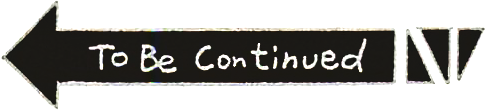

In [40]:
ete = Image.open('C:\\Users\\NULL\\Desktop\\BS_project\\meme.png')
ete

In [41]:
del ete

### After presentation additional code
#### Here I finally compare models. GaussianNB is almost the worst for this task
#### I should compare them earlier, however, due to the good data preprocess even with
#### GNB I got 90-93% accuracy while KNN is the best for this task with a ~99.9% result

In [42]:
seed = 666

In [43]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

In [44]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

In [45]:
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=3, random_state=seed)
    cv_results =  model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s : %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR : 0.185604 (0.128867)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA : 0.183740 (0.125151)
KNN : 0.195857 (0.137233)
CART : 0.161117 (0.104864)
NB : 0.177089 (0.124254)
SVM : 0.192340 (0.134064)


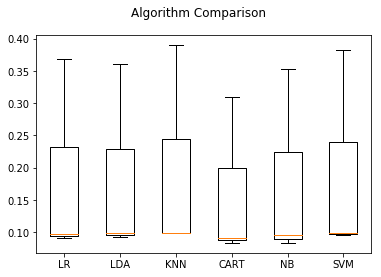

In [46]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [47]:
model1 = models[2][1] #KNN #1st best
model1.fit(X, Y)
model1_pred = model1.predict(dfp_final) #LIST WITH PREDICTED VALUES

### Ta-da!

In [48]:
accuracy_score(zoz, model1_pred, normalize = True)

1.0

In [49]:
c = 0
for guess in model1_pred:
    if (guess != zoz[c]):
        print("Prediction:  %s        True:  %s" % (guess, zoz[c]))
    c+=1

In [50]:
model2 = models[5][1] #SVM #2nd best
model2.fit(X, Y)
model2_pred = model2.predict(dfp_final) #LIST WITH PREDICTED VALUES
accuracy_score(zoz, model2_pred, normalize = True)

0.99698795180722888

In [51]:
c = 0
for guess in model2_pred:
    if (guess != zoz[c]):
        print("Prediction:  %s        True:  %s" % (guess, zoz[c]))
    c+=1

Prediction:  7        True:  1
Prediction:  7        True:  1
Prediction:  2        True:  1
Prediction:  9        True:  3
Prediction:  9        True:  3
Prediction:  9        True:  3
Prediction:  5        True:  3
Prediction:  7        True:  4
Prediction:  6        True:  5
Prediction:  6        True:  5
Prediction:  6        True:  5
Prediction:  6        True:  5
Prediction:  8        True:  6
Prediction:  1        True:  7
Prediction:  1        True:  7
Prediction:  1        True:  7
Prediction:  1        True:  7
Prediction:  6        True:  8


In [52]:
model3 = models[0][1] #LR #3rd best
model3.fit(X, Y)
model3_pred = model3.predict(dfp_final) #LIST WITH PREDICTED VALUES
accuracy_score(zoz, model3_pred, normalize = True)

0.98845381526104414

In [53]:
c = 0
for guess in model3_pred:
    if (guess != zoz[c]):
        print("Prediction:  %s        True:  %s" % (guess, zoz[c]))
    c+=1

Prediction:  9        True:  1
Prediction:  7        True:  1
Prediction:  5        True:  1
Prediction:  5        True:  1
Prediction:  7        True:  2
Prediction:  8        True:  2
Prediction:  8        True:  2
Prediction:  8        True:  2
Prediction:  1        True:  2
Prediction:  7        True:  2
Prediction:  9        True:  3
Prediction:  9        True:  3
Prediction:  9        True:  3
Prediction:  5        True:  3
Prediction:  9        True:  3
Prediction:  9        True:  3
Prediction:  5        True:  3
Prediction:  7        True:  4
Prediction:  7        True:  4
Prediction:  8        True:  4
Prediction:  1        True:  5
Prediction:  6        True:  5
Prediction:  6        True:  5
Prediction:  6        True:  5
Prediction:  6        True:  5
Prediction:  8        True:  5
Prediction:  8        True:  5
Prediction:  8        True:  5
Prediction:  8        True:  5
Prediction:  8        True:  5
Prediction:  8        True:  5
Prediction:  8        True:  5
Predicti

### Combined from the best 3 models just for fun

In [54]:
def combined(a, b, c):
    return b if (b == c) else a

In [55]:
model_comb = []
for counter in range(len(model1_pred)):
    model_comb.append(combined(model1_pred[counter], model2_pred[counter], model3_pred[counter]))
accuracy_score(zoz, model_comb, normalize = True)

0.99815930388219543

In [56]:
c = 0
for guess in model3_pred:
    if (guess != zoz[c]):
        print("Prediction:  %s        True:  %s" % (guess, zoz[c]))
    c+=1

Prediction:  9        True:  1
Prediction:  7        True:  1
Prediction:  5        True:  1
Prediction:  5        True:  1
Prediction:  7        True:  2
Prediction:  8        True:  2
Prediction:  8        True:  2
Prediction:  8        True:  2
Prediction:  1        True:  2
Prediction:  7        True:  2
Prediction:  9        True:  3
Prediction:  9        True:  3
Prediction:  9        True:  3
Prediction:  5        True:  3
Prediction:  9        True:  3
Prediction:  9        True:  3
Prediction:  5        True:  3
Prediction:  7        True:  4
Prediction:  7        True:  4
Prediction:  8        True:  4
Prediction:  1        True:  5
Prediction:  6        True:  5
Prediction:  6        True:  5
Prediction:  6        True:  5
Prediction:  6        True:  5
Prediction:  8        True:  5
Prediction:  8        True:  5
Prediction:  8        True:  5
Prediction:  8        True:  5
Prediction:  8        True:  5
Prediction:  8        True:  5
Prediction:  8        True:  5
Predicti

#### I can actually implement "combined" function better based on models' prediction percentage instead of just strict comparing 2nd and 3rd models and then to the 1st, however, I think it's enough programming for this project. Also you need some time to check this and other projects, so KNN is still the best for this task, even compare to the simple "combined" function

## Thank you

In [ ]:
%%time
for _ in range(10000000):
    print()
endtime = timeit.timeit()
print(endtime - starttime)
endtime